<a href="https://colab.research.google.com/github/yuannnnn/DATS6501/blob/main/DamageSeverity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import sys

# Mount Google Drive
drive.mount('/content/drive')

curr = '/content/drive/My Drive/Colab Notebooks/'

Mounted at /content/drive


In [ ]:
import os

if "crisis_vision_benchmarks" not in os.listdir():
    os.system("wget https://crisisnlp.qcri.org/data/crisis_image_datasets_benchmarks/crisis_vision_benchmarks.tar.gz")
    os.system("tar xf crisis_vision_benchmarks.tar.gz")

In [ ]:
import pandas as pd
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader

class CustomImageDataset(Dataset):
    def __init__(self, path, transform=None):
        self.pre = os.getcwd() + "/crisis_vision_benchmarks"
        path = pd.read_csv(path, sep='\t')
        self.img, lab = path['image_path'], path['class_label']
        self.le = LabelEncoder()
        self.le.fit(lab)
        self.labels = self.le.transform(lab)
        self.transform = transform

    def __len__(self):
        return len(self.img)

    def le(self):
        return self.le

    def __getitem__(self, idx):
        img_path = os.path.join(self.pre, self.img[idx])
        with open(img_path, 'rb') as f:
          img = Image.open(f) 
          image = img.convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop([299,299]),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "dev": transforms.Compose([
        transforms.Resize([310,310]),
        transforms.CenterCrop([299,299]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

damage_root = "/content/crisis_vision_benchmarks/tasks/damage_severity/consolidated/consolidated_damage_"

damage_dataset = {x: CustomImageDataset(damage_root + x + "_final.tsv", data_transforms[x])
                  for x in ["train", "dev"]}

damage_loader = {x: DataLoader(damage_dataset[x], batch_size=64,
                                             shuffle=True, num_workers=2)
                  for x in ["train", "dev"]}
              
damage_size = {x: len(damage_dataset[x]) for x in ["train", "dev"]}

damage_names = damage_dataset['train'].le.classes_

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
damage_test = CustomImageDataset(damage_root + "test_final.tsv", data_transforms["dev"])

test_loader = DataLoader(damage_test, batch_size=64,
                                             shuffle=True, num_workers=2)

In [ ]:
len(damage_dataset["train"]),len(damage_dataset["dev"]),len(damage_test)

(28319, 2712, 3865)

In [ ]:
import torch.optim as optim
from torch.optim import lr_scheduler

import time
import copy

In [ ]:
def train_damage(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'dev']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in damage_loader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / damage_size[phase]
            epoch_acc = running_corrects.double() / damage_size[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'dev' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_damage = models.inception_v3(pretrained=True)
model_damage.aux_logits=False
num_ftrs = model_damage.fc.in_features
model_damage.fc = nn.Linear(num_ftrs, len(damage_names))

model_damage = model_damage.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_damage = optim.SGD(model_damage.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_damage, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
model_damage = train_damage(model_damage, criterion, optimizer_damage, exp_lr_scheduler,
                       num_epochs=15)

Epoch 0/14
----------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.6563 Acc: 0.7375
dev Loss: 0.7079 Acc: 0.7046

Epoch 1/14
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.5653 Acc: 0.7760
dev Loss: 0.6461 Acc: 0.7319

Epoch 2/14
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.5332 Acc: 0.7887
dev Loss: 0.6712 Acc: 0.7205

Epoch 3/14
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.5099 Acc: 0.7982
dev Loss: 0.6412 Acc: 0.7323

Epoch 4/14
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.4936 Acc: 0.8061
dev Loss: 0.6357 Acc: 0.7330

Epoch 5/14
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.4759 Acc: 0.8114
dev Loss: 0.6497 Acc: 0.7423

Epoch 6/14
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.4648 Acc: 0.8168
dev Loss: 0.6324 Acc: 0.7400

Epoch 7/14
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.4130 Acc: 0.8390
dev Loss: 0.6250 Acc: 0.7496

Epoch 8/14
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.3948 Acc: 0.8470
dev Loss: 0.6428 Acc: 0.7529

Epoch 9/14
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.3858 Acc: 0.8503
dev Loss: 0.6449 Acc: 0.7482

Epoch 10/14
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.3755 Acc: 0.8529
dev Loss: 0.6522 Acc: 0.7504

Epoch 11/14
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.3672 Acc: 0.8548
dev Loss: 0.6643 Acc: 0.7518

Epoch 12/14
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.3584 Acc: 0.8589
dev Loss: 0.6795 Acc: 0.7544

Epoch 13/14
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.3570 Acc: 0.8605
dev Loss: 0.6908 Acc: 0.7493

Epoch 14/14
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.3499 Acc: 0.8644
dev Loss: 0.6863 Acc: 0.7489

Training complete in 232m 9s
Best val Acc: 0.754425


In [ ]:
torch.save(model_damage.state_dict(), curr+"model_damage2.pth")

In [ ]:
preds, real = [], []
for images, labels in test_loader:
  images, labels = images.to(device), labels.to(device)
  real += labels.tolist()
  with torch.no_grad():
    output = model_damage(images)
    _, predicted = torch.max(output, 1)
    preds += predicted.tolist()

In [ ]:
from sklearn import metrics
print(metrics.classification_report(real, preds, target_names=damage_names))

                precision    recall  f1-score   support

little_or_none       0.84      0.87      0.86      2135
          mild       0.44      0.37      0.40       629
        severe       0.74      0.75      0.74      1101

      accuracy                           0.76      3865
     macro avg       0.67      0.66      0.67      3865
  weighted avg       0.75      0.76      0.75      3865



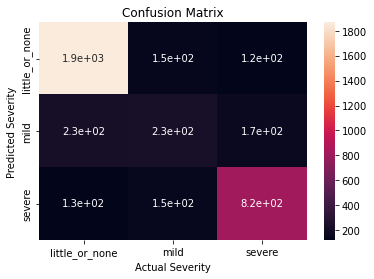

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

cm = metrics.confusion_matrix(real, preds)
f = sns.heatmap(cm, annot=True, xticklabels=damage_names, yticklabels=damage_names)
plt.title("Confusion Matrix")
plt.xlabel("Actual Severity")
plt.ylabel("Predicted Severity") 
plt.show()